复习一下，粘贴进jupyter形式。
要注意各方法的输入输出，并添加相应的注释。开始吧！
环境：教程推荐torch1.3+python3.6，我使用的环境torch2.0+python3.11

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import numpy as np
import copy
from torch.autograd import Variable

In [20]:
class Embeddings(nn.Module):
    """ 构建Embedding类实现文本嵌入层，将每个token编码为[d_model]维度\n
        定义时输入：d_model词嵌入维度、vocab词表大小--用于embedding\n
        输入：[m, n]\n
        输出：[m, n, d_model] """
    def __init__(self, d_model, vocab):
        """
        d_model: 词嵌入维度
        vocab: 词表大小
        """
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        """ x代表输入进模型的文本通过词汇映射后的张量 """
        return self.lut(x) * math.sqrt(self.d_model)

In [21]:
""" 测试Embeddings类 """
d_model = 512
vocab = 1000
x = Variable(torch.LongTensor([[100, 2, 421, 508],
                               [491, 998, 1, 221]]))
emb = Embeddings(d_model, vocab)
embr = emb(x)
print(f'embr:{embr}\n{embr.shape}')

embr:tensor([[[-10.3362, -17.2049,  -8.8409,  ...,  43.4437,  -5.5588,  36.3984],
         [-14.9257,  53.6641,  -6.0153,  ...,  25.1397,   2.8370,  -6.7625],
         [-19.1275,  17.1257,   8.4271,  ..., -10.5427, -15.9910,   1.2411],
         [ -0.4714,  -8.4545,  -6.1369,  ...,  -0.5820,  27.4585,  -2.2529]],

        [[-21.7611, -50.9096,  14.5166,  ...,  25.0023,   4.1707,  18.1425],
         [ -1.4335,  -4.4078,  76.3626,  ..., -25.0362,  46.1580, -30.3227],
         [ -6.4553,  -8.8110, -22.4837,  ..., -21.0540,   9.1541,  30.7186],
         [ 46.3685,   4.8490, -12.1640,  ...,  -8.7192, -41.5839,  14.0993]]],
       grad_fn=<MulBackward0>)
torch.Size([2, 4, 512])


In [22]:
m = nn.Dropout(p=.2)
input1 = torch.randn(4, 5)
output = m(input1)      # 会有4*5*0.2个元素被置零
print(output)

x = torch.tensor([1, 2, 3, 4])  # [4]
y = torch.unsqueeze(x, 0)       # [1, 4]
print(y, y.shape)
z = torch.unsqueeze(x, 1)       # [4, 1]
print(z, z.shape)

tensor([[ 1.2996, -0.7557,  0.0000, -0.0000,  0.0232],
        [-2.4522,  1.3946, -1.2816,  0.0000, -2.1936],
        [-1.2174, -0.0000,  0.2671,  0.7763, -0.6813],
        [ 0.0000,  0.0000, -1.3564, -2.0088, -1.6104]])
tensor([[1, 2, 3, 4]]) torch.Size([1, 4])
tensor([[1],
        [2],
        [3],
        [4]]) torch.Size([4, 1])


In [23]:
class PositionalEncoding(nn.Module):
    """ 构建位置编码器类\n
        定义时输入：d_model词嵌入维度 dropout置零比率 max_len句子最大长度\n
        生成位置编码self.pe [1, max_len, d_model]，其实就是一句话的位置编码 batch中每句话都加上相同的位置编码，1为了后面匹配维度，有max_len个词 * 每个词d_model维度\n
        输入：文本序列的词嵌入表示x [batch 2, tokens 4, d_model 512]  看一下self.pe与输入x的形状可知，x有batch个样本，每个样本(即一句话)都会加上相同的self.pe\n
        输出：经过了位置嵌入的x，相当于每个每个元素上加了一个表示位置的值 形状没变[batch 2, tokens 4, d_model 512] """
    def __init__(self, d_model, dropout, max_len=5000):
        # d_model: 词嵌入维度
        # dropout: 置零比率
        # max_len：每个句子最大长度
        super(PositionalEncoding, self).__init__()

        # 实例化dropout层
        self.dropout = nn.Dropout(p=dropout)

        # 初始化位置编码矩阵, 大小是max_len * d_model  有多少个词 * 每个词多大
        pe = torch.zeros(max_len, d_model)

        # 初始化绝对位置矩阵     max_len * 1
        position = torch.arange(0, max_len).unsqueeze(1)

        # 定义一个变换矩阵div_term，跳跃式的初始化  形状 [d_model / 2] 因为要分别初始化pe的 偶数索引 和 奇数索引
        div_term = torch.exp(torch.arange(0, d_model, 2) * -(math.log(10000.) / d_model))

        # 将前面定义的变换矩阵div_term，分别用于pe的偶数位置、奇数位置的赋值
        # position * div_term 形状的二维矩阵，各行列值均不同，因此能作为位置编码
        pe[:, 0::2] = torch.sin(position * div_term)    # [max_len, 1] * [d_model / 2] --> [max_len=60, d_model / 2=256] 应该自动调用了广播机制
        pe[:, 1::2] = torch.cos(position * div_term)

        # 将二维张量扩充成三维张量  60 * 512 --> 1 * 60 * 512
        pe = pe.unsqueeze(0)

        # 将位置编码矩阵注册成模型的buffer，这个buffer不是模型中的参数，不跟随优化器同步更新
        # 注册成buffer后，我们就可以在模型保存后重新加载时，将这个位置编码器和模型参数加载进来
        # register_buffer()通常用于注册不应被视为模型参数的缓冲区，同时，模型保存和加载的时候可以写入和读出
        # pytorch一般情况下，是将网络中的参数保存成orderedDict形式的，这里的参数其实包含两种：
        #   一种是模型中各种module含的参数，即nn.Parameter,我们当然可以在网络中定义其他的nn.Parameter参数，
        #   另一种就是buffer
        #   前者每次optim.step会得到更新，而不会更新后者。
        self.register_buffer('pe', pe)

    def forward(self, x):
        # x: 代表文本序列的词嵌入表示   [batch 2, tokens 4, d_model 512]
        # 首先明确pe的编码太长了，将第二个维度也就是max_len对应的维度缩小成x的句子长度
        # x.size(1)表示本句话的tokens数量，即对位置嵌入截断为句子长度，我只需要句子长度的位置编码
        print(f'$$$$$$$$$$$$ 输入x {x.shape} self.pe {self.pe.shape}')
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)   # requires_grad=False 代表位置编码不参与未来梯度更新；残差连接应该用了广播机制
        print(f'$$$$$$$$$$$$ 输出x {x.shape}')
        return self.dropout(x)

In [24]:
""" 测试PositionalEncoding类 """
d_model = 512
dropout = .1
max_len = 60

x = embr    # 文本的词嵌入结果 [2, 4, 512]
pe = PositionalEncoding(d_model, dropout, max_len)
pe_result = pe(x)       # [2, 4, 512]
print(f'{pe_result}\n{pe_result.shape}')

$$$$$$$$$$$$ 输入x torch.Size([2, 4, 512]) self.pe torch.Size([1, 60, 512])
$$$$$$$$$$$$ 输出x torch.Size([2, 4, 512])
tensor([[[-11.4847, -18.0054,  -9.8232,  ...,  49.3819,  -6.1764,  41.5538],
         [-15.6491,  60.2271,  -5.7704,  ...,  29.0441,   3.1523,  -6.4028],
         [-20.2425,  18.5662,  10.4039,  ..., -10.6031, -17.7676,   2.4901],
         [ -0.3670, -10.4938,  -6.5464,  ...,   0.4645,  30.5098,  -0.0000]],

        [[-24.1790, -55.4551,   0.0000,  ...,  28.8915,   4.6341,  21.2695],
         [ -0.6578,  -4.2972,  85.7605,  ..., -26.7069,  51.2868, -32.5808],
         [ -0.0000, -10.2524, -23.9415,  ..., -22.2822,  10.1715,  35.2429],
         [  0.0000,   0.0000, -13.2432,  ...,  -0.0000, -46.2040,  16.7770]]],
       grad_fn=<MulBackward0>)
torch.Size([2, 4, 512])


$$$$$$$$$$$$ 输入x torch.Size([1, 100, 20]) self.pe torch.Size([1, 5000, 20])
$$$$$$$$$$$$ 输出x torch.Size([1, 100, 20])


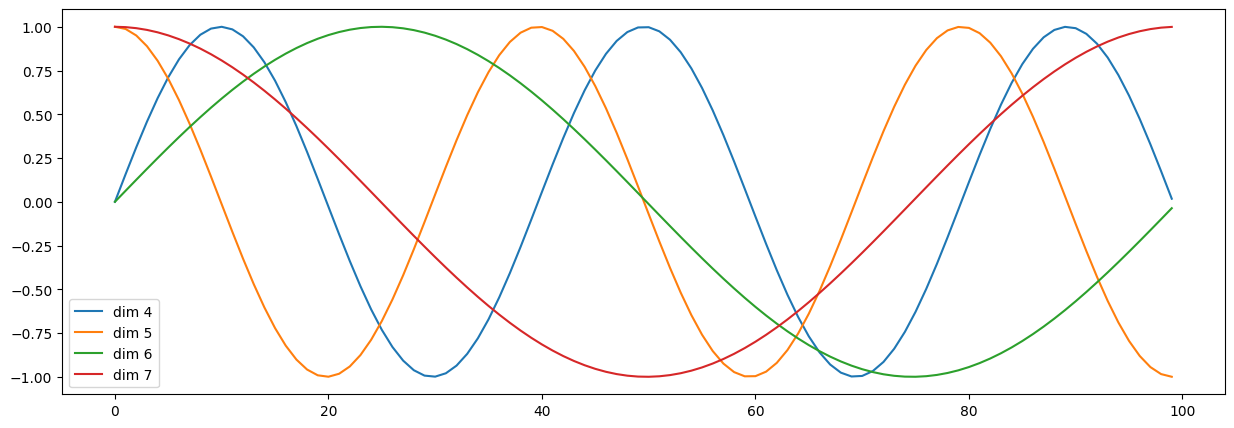

In [25]:
""" 可视化一下PositionalEncoding结果 """
# 第一步 设置一个画布
plt.figure(figsize=(15, 5))

# 第二步 实例化PositionalEncoding对象，词嵌入维度20，置零比率0
pe = PositionalEncoding(d_model=20, dropout=0)

# 向pe中传入全0初始化的x，相当于展示pe
y = pe(Variable(torch.zeros(1, 100, 20)))   # 100意味着：PositionalEncoding中为每句话生成了max_len=5000个token位置，但我只取前100个

plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())     # 此处嵌入维度为20，我们只可视化4 5 6 7维度，即4条线

plt.legend(['dim %d' % p for p in [4, 5, 6, 7]])
plt.show()

In [26]:
""" 上/下三角矩阵 np.triu() """
# 参数k表示要保留的位置
print(np.triu([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]], k=-1))   # k=-1，即k=0向下移动一行
print(np.triu([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]], k=0))    # k=0即矩阵第0行第0列起始的对角线保留
print(np.triu([[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]], k=1))    # k=1，即k=0向上移动一行

[[ 1  2  3]
 [ 4  5  6]
 [ 0  8  9]
 [ 0  0 12]]
[[1 2 3]
 [0 5 6]
 [0 0 9]
 [0 0 0]]
[[0 2 3]
 [0 0 6]
 [0 0 0]
 [0 0 0]]


In [27]:
def subsequent_mask(size):
    """ 构建掩码张量的函数 返回对角线为1的下三角矩阵 [1, size, size]\n
        [size, size]维度，把每列视为一个进行遮挡的张量，我们得到的不是下三角矩阵嘛，也就是下半部是1，上半部分是0，教程说1表示遮挡 """
    # size: 掩码张量后两个维度，形成一个方阵
    attn_shape = (1, size, size)

    # 使用np.ones()先构建全1张量，利用np.triu()形成上三角矩阵
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')

    # 使得三角矩阵反转
    return torch.from_numpy(1 - subsequent_mask)

tensor([[[1, 0, 0, 0, 0],
         [1, 1, 0, 0, 0],
         [1, 1, 1, 0, 0],
         [1, 1, 1, 1, 0],
         [1, 1, 1, 1, 1]]], dtype=torch.uint8) torch.Size([1, 5, 5])


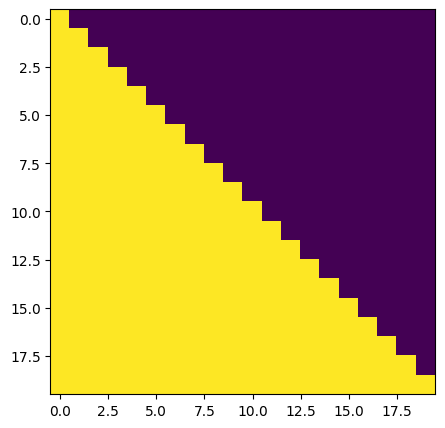

tensor([[ 0.6750,  0.6970,  0.8212,  0.1977, -0.5449],
        [ 0.1728, -2.1089, -0.3602, -1.0229,  1.4431],
        [ 0.2328, -0.4673,  0.3563,  0.0522,  0.3903],
        [-0.3012, -1.4493, -1.7866, -0.2860,  0.4581],
        [-0.3248,  0.4218, -0.4362,  1.1343, -1.4353]])
tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])
tensor([[-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09],
        [-1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09, -1.0000e+09]])


In [28]:
""" 测试subsequent_mask()方法 """
size = 5
sm = subsequent_mask(size)      # [1, 5, 5]
print(sm, sm.shape)

plt.figure(figsize=(5, 5))
plt.imshow(subsequent_mask(20)[0])  # 返回的是3维张量 [0]降维一下
plt.show()

x = Variable(torch.randn(5, 5))
print(x)

mask = Variable(torch.zeros(5, 5))
print(mask)

y = x.masked_fill(mask == 0, -1e9)
print(y)

In [29]:
def attention(query, key, value, mask=None, dropout=None):
    """ q k v：代表注意力的三个输入 应该都是三维的[batch, tokens, d_model] 也就是经过embedding、position_embedding的结果\n
        mask: [batch 2, tokens 4, tokens 4] 掩码张量，用于scores\n
        dropout: 实例化对象\n
        return: scores与value的矩阵乘、scores；形状分别为[batch, tokens, d_model]  [batch, tokens, tokens] """
    # 首先将query最后的维度提取出来，代表的是词嵌入的维度
    d_k = query.size(-1)

    # 这里是在计算权重；按照注意力计算公式，将q k转置进行matmul，除以缩放系数d_k
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)    # 是吗[batch, tokens, tokens], 是的 [2, 4, 4]
    # print(f'$$$$$$$$$$$$$$$$ {scores.shape}')

    # 判断是否使用掩码张量
    if mask is not None:
        # 利用masked_fill()，将掩码张量和0进行位置的一一比较，等于0则替换成非常小的数
        scores = scores.masked_fill(mask == 0, -1e9)

    # 对scores最后一个维度进行softmax 得到对所有value注意力权重
    p_attn = F.softmax(scores, dim=-1)      # [2, 4, 4]

    # 判断是否使用dropout
    if dropout is not None:
        p_attn = dropout(p_attn)

    # 最后一步完成p_attn和val张量的乘法，并返回query的注意力表示
    return torch.matmul(p_attn, value), p_attn      # [2, 4, 512], [2, 4, 4]

In [30]:
""" 测试attention()方法 """
query = key = value = pe_result     # [batch 2, tokens 4, d_model 512]  pe_result是经过embedding、position embedding后的结果
mask = Variable(torch.zeros(2, 4, 4))   # [batch, tokens, tokens] 因为要应用到scores上
attn, p_attn = attention(query, key, value, mask=mask)      # 传入一个全0的mask，则计算的scores = matmul(q, k.t)结果全为非常小的值了，之后softmax结果也会都一样
print(f'attn:{attn}\n{attn.shape}\np_attn:{p_attn}\n{p_attn.shape}')

attn:tensor([[[-11.9358,  12.5735,  -2.9340,  ...,  17.0719,   2.4295,   9.4103],
         [-11.9358,  12.5735,  -2.9340,  ...,  17.0719,   2.4295,   9.4103],
         [-11.9358,  12.5735,  -2.9340,  ...,  17.0719,   2.4295,   9.4103],
         [-11.9358,  12.5735,  -2.9340,  ...,  17.0719,   2.4295,   9.4103]],

        [[ -6.2092, -17.5012,  12.1440,  ...,  -5.0244,   4.9721,  10.1771],
         [ -6.2092, -17.5012,  12.1440,  ...,  -5.0244,   4.9721,  10.1771],
         [ -6.2092, -17.5012,  12.1440,  ...,  -5.0244,   4.9721,  10.1771],
         [ -6.2092, -17.5012,  12.1440,  ...,  -5.0244,   4.9721,  10.1771]]],
       grad_fn=<UnsafeViewBackward0>)
torch.Size([2, 4, 512])
p_attn:tensor([[[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500]],

        [[0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
         [0.2500, 0.2500, 0.2500, 0.2500],
   

In [31]:
""" 改变tensor形状/维度 """
x = torch.randn(4, 4)
print(x.size(), x.shape)
y = x.view(16)
print(y.size())
z = x.view(-1, 8)
print(z.shape)

torch.Size([4, 4]) torch.Size([4, 4])
torch.Size([16])
torch.Size([2, 8])


In [32]:
""" 体会transpose()与view()的区别 
    transpose()真正交换维度信息，view()重新排列元素 """
a = torch.randn(1, 2, 3, 4)
print(a.shape)
print(a)
b = a.transpose(1, 2)
print(b.shape)
print(b)

c = a.view(1, 3, 2, 4)      # transpose()、view()形状虽然相同，但结果并不同
print(c.shape)
print(c)

torch.Size([1, 2, 3, 4])
tensor([[[[-3.3307e+00,  1.9622e+00, -7.7699e-01, -1.7111e+00],
          [ 2.7328e+00, -4.1081e-01,  5.0962e-01, -1.5073e-01],
          [ 9.0966e-01, -1.0728e-03, -1.5174e-01, -1.2408e+00]],

         [[-3.3837e-01,  5.0058e-01,  1.4475e+00,  3.2439e-01],
          [-8.7699e-03, -1.5389e+00, -1.4992e+00, -3.6105e-01],
          [ 5.2221e-01, -9.4056e-01,  1.4608e-01, -1.1061e-01]]]])
torch.Size([1, 3, 2, 4])
tensor([[[[-3.3307e+00,  1.9622e+00, -7.7699e-01, -1.7111e+00],
          [-3.3837e-01,  5.0058e-01,  1.4475e+00,  3.2439e-01]],

         [[ 2.7328e+00, -4.1081e-01,  5.0962e-01, -1.5073e-01],
          [-8.7699e-03, -1.5389e+00, -1.4992e+00, -3.6105e-01]],

         [[ 9.0966e-01, -1.0728e-03, -1.5174e-01, -1.2408e+00],
          [ 5.2221e-01, -9.4056e-01,  1.4608e-01, -1.1061e-01]]]])
torch.Size([1, 3, 2, 4])
tensor([[[[-3.3307e+00,  1.9622e+00, -7.7699e-01, -1.7111e+00],
          [ 2.7328e+00, -4.1081e-01,  5.0962e-01, -1.5073e-01]],

         [[ 9.0

In [33]:
# 实现深层拷贝/克隆函数，因为多头注意力机制下，要用到多个 结构相同但参数不同 的线性层
# 需要使用clone()函数将他们一同初始化到一个网络层列表对象中
def clones(module, N):
    """
    module: 代表要克隆的目标网络层\n
    N: 将module克隆几个\n
    return: nn.ModuleList()
    """
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [34]:
# 实现多头注意力机制类
class MultiHeadedAttention(nn.Module):
    """
    多个head均分d_model嵌入维度处理\n
    定义输入：\n
    输入：q k v [batch, tokens, d_model], mask [head, tokens, tokens]\n
    输出：[batch, tokens, head * d_k = embedding_dim]\n
    """
    def __init__(self, head, embedding_dim, dropout=.1):
        """
        :param head: 代表几个头
        :param embedding_dim: 词嵌入维度
        :param dropout: 置零比率
        """
        super(MultiHeadedAttention, self).__init__()

        # 要确认一个事实：多头的数量head需要整除词嵌入维度embedding_dim
        assert embedding_dim % head == 0

        # 得到每个头获得的词向量维度
        self.d_k = embedding_dim // head

        self.head = head
        self.embedding_dim = embedding_dim

        # 获得线性层，要获得4个，分别是Q K V以及最终的输出线性层
        self.linears = clones(nn.Linear(embedding_dim, embedding_dim), 4)

        # 初始化注意力张量
        self.attn = None

        # 初始化dropout对象
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        """ query key value是多头注意力机制的三个输入张量 [batch, tokens, d_model]\n
            mask 掩码张量 [head, tokens, tokens] """
        # 首先判断是否使用掩码张量
        if mask is not None:
            # 使用squeeze将掩码张量进行维度扩充，代表多头中的第n个头
            # 【这里我怀疑教程讲错了，教程升维是[1]，运行报错；我改为[0]，可正常运行】
            mask = mask.unsqueeze(0)

        # 获得batch_size
        batch_size = query.size(0)

        # 首先使用zip将网络层和输入数据连接在一起，模型的输出利用view和transpose进行维度和形状的改变
        # for循环中model(x)的结果要view()改变形状[batch_size, tokens词的数量即句子长度, 多少个头, 每个头分得的维度]      view()重排列元素，transpose()交换维度
        # transpose(), 因为想把头的数量往前，-1与词嵌入维度连接到一起
        query, key, value = \
            [model(x).view(batch_size, -1, self.head, self.d_k).transpose(1, 2)
                for model, x in zip(self.linears, (query, key, value))]     # [batch, head, tokens, d_k]

        # 将每个头的输出传入到注意力层
        # for循环将输入的qkv经过fc，均分到每个head，然后送入以下attention()，得到多头注意力计算结果
        # attention()计算只用到了最后两个维度 tokens和d_k，这也是其作为单头时的使用维度；现在的输入相比单头时多了head维度，attention()只对后两个维度计算，也就是分别对head计算，从而达到多头注意力的效果
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)    # [batch, head, tokens, d_k] [batch, head, tokens, tokens]

        # 得到每个头的计算结果是4维张量，需要进行形状的转换
        # 前面已经将1 2两个维度进行过转置，这里要重新转置回来
        # 注意：经历了transpose()后，必须要用contiguous()，不然无法使用view()
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.head * self.d_k)   # 最终[batch, tokens, head * d_k = embedding_dim]

        # 最后将x输入最后一个线性层，得到最终的多头注意力结构输出
        return self.linears[-1](x)


In [35]:
""" 测试MultiHeadedAttention类 """
# 实例化若干参数
head = 8    # 8个头均分512维处理
embedding_dim = 512
dropout = .2

# 输入参数
query = key = value = pe_result     # [2, 4, 512]

# 之前 单头测试 attention()方法时，mask维度是[batch, tokens, tokens]；
# 这里 多头测试 MultiHeadedAttention类，mask维度是[head, tokens, tokens]
mask = Variable(torch.zeros(8, 4, 4))

mha = MultiHeadedAttention(head, embedding_dim, dropout)
mha_result = mha(query, key, value, mask)   # 应该还是[2, 4, 512] 因为Transformer输入输出不变，代码里面也是不变
print(mha_result, mha_result.shape)

tensor([[[ 0.2554,  5.9248, -5.3822,  ..., -1.6650,  3.6736, -0.3923],
         [ 0.8243,  5.5068, -4.2782,  ...,  2.9770, -3.1080, -0.0614],
         [-1.4744,  3.8637, -5.4936,  ...,  2.3212,  1.0325, -0.9782],
         [-3.0931,  1.7402, -4.9292,  ...,  3.0447,  0.5944,  3.7281]],

        [[ 1.4655, -3.7037, -7.4489,  ..., -1.0291,  2.9283, -3.4573],
         [ 2.3721, -1.1518, -5.7020,  ...,  0.3615,  3.6224, -2.9213],
         [-0.0214, -6.2571, -5.4127,  ..., -1.4258,  4.3200, -3.3622],
         [ 0.6595, -6.3244, -5.5390,  ..., -5.6162,  1.5001, -2.7878]]],
       grad_fn=<ViewBackward0>) torch.Size([2, 4, 512])


In [37]:
# 构建前馈全连接网络类
class PositionWiseFeedForward(nn.Module):
    """
    forward输入：经过多头自注意力层的输出x [batch, tokens, d_model]
    forward输出：输入输出形状不变
    """
    def __init__(self, d_model, d_ff, dropout=.1):
        """
        :param d_model: 词嵌入维度，同时也是两个线性层的输入维度和输出维度
        :param d_ff: 第一个线性层的输出维度，和第二个线性层的输入维度
        :param dropout: 随机置零比率
        """
        super(PositionWiseFeedForward, self).__init__()

        # 定义两层全连接的fc
        self.w1 = nn.Linear(d_model, d_ff)
        self.w2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """ x: 来自上一层的输出 """
        # 首先将x送入第一个fc，然后经历relu，再经历dropout
        # 最后送入第二个fc
        return self.w2(self.dropout(F.relu(self.w1(x))))


In [38]:
""" 测试前馈全连接网络层的类 """
d_model = 512
d_ff = 64
dropout = .2

x = mha_result
print(x.shape)
ff = PositionWiseFeedForward(d_model, d_ff, dropout)
ff_result = ff(x)
print(ff_result)
print(ff_result.shape)

torch.Size([2, 4, 512])
tensor([[[ 0.4274,  0.2143, -0.8172,  ...,  0.4647, -0.8675,  0.9472],
         [-0.7170, -0.3033,  0.0442,  ...,  0.5514,  0.1777, -0.1559],
         [ 0.2484, -0.1068, -0.7263,  ..., -0.3304, -1.5175,  0.4548],
         [-0.1512, -0.2588, -0.3990,  ..., -0.6600, -1.4496,  0.0749]],

        [[ 1.9111, -2.3885, -0.2596,  ..., -0.3596,  0.5511,  2.1404],
         [ 0.5706, -2.2469, -0.6225,  ..., -0.6240,  0.9194,  2.2830],
         [ 0.2763, -1.9381, -0.6512,  ..., -0.4740, -0.1389,  1.8359],
         [ 0.3724, -1.7899,  0.0121,  ..., -0.5377, -0.5441,  1.4674]]],
       grad_fn=<ViewBackward0>)
torch.Size([2, 4, 512])


In [39]:
# 构建规范层类
class LayerNorm(nn.Module):
    """ 定义输入：词嵌入维度  均值、方差都在这个维度上求，词嵌入维度-->得到1个数[方差或均值]
            输入：上一层网络的输出x [batch, tokens, d_model]
            输出：对每个样本规范化后的结果，确实使用的LN，即对每个样本规范化，使用到了广播机制 形状仍是[batch, tokens, d_model] """
    def __init__(self, features, eps=1e-6):
        """
        :param features: 词嵌入维度
        :param eps: 一个足够小的正数
        """
        super(LayerNorm, self).__init__()

        # 初始化两个参数张量 a2、b2，用于对结果做规范化计算
        # 将其用nn.Parameter封装，代表也是模型参数
        self.a2 = nn.Parameter(torch.ones(features))
        self.b2 = nn.Parameter(torch.zeros(features))

        self.eps = eps

    def forward(self, x):
        """ x: 上一层网络的输出 """
        # 首先对x求最后维度上的均值，同时keepdim
        mean = x.mean(dim=-1, keepdim=True)     # [2, 4, 512] -> [2, 4, 1] 如果没有keepdim=True，得到的形状是[2, 4]
        # 接着对x求最后维度上的标准差，同时keepdim
        std = x.std(dim=-1, keepdim=True)       # [2, 4, 512] -> [2, 4, 1]
        # 按照规范化公式进行计算并返回
        # x形状[2, 4, 512] mean形状[2, 4, 1], 也就是x的512维度每个数都减去mean的为1的维度, 广播机制。确实是对batch的每个样本操作，符合LN
        return self.a2 * (x - mean) / (std + self.eps) + self.b2

In [40]:
""" 测试规范化层类 """
features = d_model = 512
eps = 1e-6

x = ff_result   # [2, 4, 512]
ln = LayerNorm(features, eps)
ln_result = ln(x)       # [2, 4, 512]
print(ln_result, ln_result.shape)

tensor([[[ 0.4734,  0.1937, -1.1596,  ...,  0.5223, -1.2256,  1.1553],
         [-0.9203, -0.3902,  0.0551,  ...,  0.7049,  0.2261, -0.2013],
         [ 0.1943, -0.1447, -0.7359,  ..., -0.3581, -1.4910,  0.3913],
         [-0.2078, -0.3359, -0.5027,  ..., -0.8135, -1.7535,  0.0614]],

        [[ 1.5657, -2.0709, -0.2702,  ..., -0.3548,  0.4154,  1.7596],
         [ 0.4387, -1.9780, -0.5847,  ..., -0.5860,  0.7378,  1.9074],
         [ 0.1281, -1.7682, -0.6662,  ..., -0.5144, -0.2275,  1.4637],
         [ 0.2586, -1.8074, -0.0856,  ..., -0.6109, -0.6171,  1.3049]]],
       grad_fn=<AddBackward0>) torch.Size([2, 4, 512])


In [41]:
# 构建子层连接结构的类
class SublayerConnection(nn.Module):
    """ 子层结构：Sublayer + LN + Residual。其实就是指的如Encoder的某一子层。
        定义输入：d_model(因为要进行规范化)、dropout
        输入：x(嵌入+位置嵌入的结果 [batch, tokens, d_model]) and sublayer子层函数(是个函数)
        输出："""
    def __init__(self, size, dropout=.1):
        """
        :param size: 词嵌入维度
        :param dropout: 置零比率
        """
        super(SublayerConnection, self).__init__()
        # 实例化一个规范化层的对象
        self.norm = LayerNorm(size)
        # 实例化一个dropout对象
        self.dropout = nn.Dropout(dropout)
        self.size = size

    def forward(self, x, sublayer):
        """
        :param x: 上一层传入的张量
        :param sublayer: 该子层连接中的子层函数
        :return:
        """
        # 首先将x进行规范化，然后送入子层函数处理，处理结果进入dropout层，最后进行残差连接
        return x + self.dropout(sublayer(self.norm(x)))     # 这里之所以dropout，是因为MHA中最后的输出是经过fc的；Transformer应该先过sublayer、再LN？

In [42]:
""" 测试子层连接结构的类 """
size = d_model = 512
head = 8
dropout = .2

x = pe_result       # [2, 4, 512]
mask = Variable(torch.zeros(8, 4, 4))
self_attn = MultiHeadedAttention(head, d_model)

sublayer = lambda x: self_attn(x, x, x, mask)

sc = SublayerConnection(size, dropout)
sc_result = sc(x, sublayer)     # [2, 4, 512]
print(sc_result, sc_result.shape)

tensor([[[-1.1301e+01, -1.7761e+01, -9.8232e+00,  ...,  4.9646e+01,
          -6.2575e+00,  4.1575e+01],
         [-1.5451e+01,  6.0388e+01, -5.6699e+00,  ...,  2.9264e+01,
           3.1523e+00, -6.3097e+00],
         [-2.0028e+01,  1.8690e+01,  1.0583e+01,  ..., -1.0353e+01,
          -1.7825e+01,  2.4901e+00],
         [-1.1127e-01, -1.0240e+01, -6.5464e+00,  ...,  7.5614e-01,
           3.0510e+01,  1.1779e-01]],

        [[-2.3722e+01, -5.5523e+01, -4.7752e-02,  ...,  2.9142e+01,
           4.3264e+00,  2.1415e+01],
         [-6.5779e-01, -4.2972e+00,  8.5668e+01,  ..., -2.6539e+01,
           5.0968e+01, -3.2488e+01],
         [ 3.9642e-01, -1.0563e+01, -2.4023e+01,  ..., -2.2118e+01,
           9.9359e+00,  3.5217e+01],
         [ 0.0000e+00, -8.2793e-02, -1.3371e+01,  ...,  0.0000e+00,
          -4.6462e+01,  1.6777e+01]]], grad_fn=<AddBackward0>) torch.Size([2, 4, 512])


In [43]:
# 构建编码器层类
class EncoderLayer(nn.Module):
    """ 可以这么想，EncoderLayer类实现了一个完整的Encoder——MSA+FF，即两个子层连接网络结构 
        定义输入：size,【MSA对象、FF对象】, dropout 
        输入：x、mask 
        输出："""
    def __init__(self, size, self_attn, feed_forward, dropout):
        """
        :param size: 词嵌入维度
        :param self_attn: 多头自注意力子层的实例化对象
        :param feed_forward: 前馈全连接层实例化对象
        :param dropout: 置零比率
        """
        super(EncoderLayer, self).__init__()

        # 将两个实例化对象和参数传入类中
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.size = size

        # 编码器层中有2个子层连接结构，使用clone()
        self.sublayer = clones(SublayerConnection(size, dropout), 2)

    def forward(self, x, mask):
        """
        :param x: 上一层的传入张量
        :param mask: 掩码张量
        :return:
        """
        # 首先让x经过第一个子层连接结构，内部包含多头自注意力机制子层
        # 再让张量经过第二个子层连接结构，其中包含前馈全连接网络
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

In [44]:
""" 测试EncoderLayer类，即构建了一个完整的Encoder """
size = d_model = 512
head = 8
d_ff = 64
x = pe_result   # 经过了embedding+pos_embedding的结果
dropout = .2

self_attn = MultiHeadedAttention(head, d_model)
ff = PositionWiseFeedForward(d_model, d_ff, dropout)
mask = Variable(torch.zeros(8, 4, 4))   # [适应多头的head维度, tokens, tokens]

el = EncoderLayer(size, self_attn, ff, dropout)
el_result = el(x, mask)     # [2, 4, 512]
print(el_result, el_result.shape)

tensor([[[-1.0439e+01, -1.7815e+01, -1.0112e+01,  ...,  4.8730e+01,
          -6.4055e+00,  4.2141e+01],
         [-1.4443e+01,  6.0890e+01, -5.6624e+00,  ...,  2.9644e+01,
           2.9061e+00, -6.0784e+00],
         [-2.0173e+01,  1.8226e+01,  1.0249e+01,  ..., -1.0603e+01,
          -1.8330e+01,  2.6604e+00],
         [ 3.0283e-01, -1.0411e+01, -6.6409e+00,  ...,  1.0121e+00,
           3.0039e+01, -5.1982e-01]],

        [[-2.4179e+01, -5.5010e+01,  0.0000e+00,  ...,  2.8436e+01,
           4.6341e+00,  2.1528e+01],
         [-5.7467e-01, -3.7001e+00,  8.5553e+01,  ..., -2.6696e+01,
           5.0500e+01, -3.2361e+01],
         [ 3.5686e-01, -9.9564e+00, -2.4399e+01,  ..., -2.2515e+01,
           9.7643e+00,  3.5236e+01],
         [-2.3693e-03,  5.1484e-01, -1.3375e+01,  ..., -4.0520e-02,
          -4.6529e+01,  1.6777e+01]]], grad_fn=<AddBackward0>) torch.Size([2, 4, 512])
